# Stat 143 Final Project

## Elo System for 9-ball Pool

Dasha Metropolitansky, Seth Billiau, Sarah Lucioni


We aim to create a ranking for 9-ball pool using data from 2010-2020. In our background research, we did not find an Elo system currently in use for 9-ball pool rankings. An Elo system is likely a good application in pool because it is a zero-sum game. In this project, we first calibrate a basic Elo system, apply a handful of improvements, then extend our ranking scheme to a Glicko2 system. 

In [82]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime
import math

# Elo 

In [64]:
# Load validation dataset (from a 2021 tournament) 
val_data = pd.read_csv('data/predatorCLPClean.csv')
val_data['date'] = pd.to_datetime(val_data['date'])

# Load the entire dataset (years 2010 - 2020)
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [65]:
val_data.head()

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP


In [66]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

# List of player names
players = pd.concat([fulldf.playerA, fulldf.playerB])
print(players.value_counts().index.unique())

# Total number of players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Niels Feijen', 'Ralf Souquet', 'Albin Ouschan',
       'Jayson Shaw', 'Eklent Kaci', 'Joshua Filler', 'David Alcaide',
       'Alex Kazakis', 'Darren Appleton',
       ...
       'Shannon Murphy', 'Vincent Facquet', 'Saad-Ali Aldrees',
       'Manuel Ederer', 'Ramon Mistica', 'Kristina Tkach', 'Phi Le',
       'Stephen Webber', 'Reymart Lin', 'Gindac Ciprian Gabriel'],
      dtype='object', length=1182)


1182

In [67]:
def expected(A, B, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate player A's expected score which is equivalent to the probability that player A wins in this 
    pool scenario since we do not track draws.
    (https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)
    
    params
    A: Player A's current elo rating
    B: Player B's current elo rating
    ELO_WIDTH: Elo system rating change constant
    
    return 
    proba: the probability that player A wins
    '''
    proba = 1 / (1 + 10 ** ((B - A) / ELO_WIDTH))
    return proba


def update_elo(winner_elo, loser_elo, K, ELO_WIDTH = ELO_WIDTH):
    '''
    Update the winner and loser elo ratings.
    
    params
    winner_elo: Winning player's elo rating at time of match
    loser_elo: Losing player's elo rating at time of match
    K: Update parameter
    ELO_WIDTH: Elo system rating change constant
    
    return 
    winner_elo: Winning player's updated elo rating
    loser_elo: Losing player's updated elo rating
    '''
    expected_win = expected(winner_elo, loser_elo, ELO_WIDTH)
    change_in_elo = K * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def get_winner_loser(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9).
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
    else: 
        winner = row['playerB']
        loser = row['playerA']
        
    return winner, loser


def run_tournament(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [68]:
ratings = run_tournament(fulldf)
ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Jayson Shaw,1971.387195
Eklent Kaci,1924.002866
Fedor Gorst,1920.977075
Liu Haitao,1829.592959
Jung-Lin Chang,1825.054499
Maximilian Lechner,1822.385942
Joshua Filler,1793.461234
Niels Feijen,1776.715053
Alex Pagulayan,1771.201078
Francisco Sanchez Ruiz,1763.975621


In [69]:
# Players in the validation set
players_val = pd.concat([val_data.playerA, val_data.playerB])

In [98]:
# Get validation players in predicted ratings 

# TODO: clean this up? playersindex and names are equivalent
def get_CLPratings(ratings):

    # get players index
    playersindex = []
    for player in players_val.unique():
        if player in ratings.index:
            playersindex.append(np.where(players.value_counts().index == player)[0][0])
    
    # Get player list
    players.value_counts()[playersindex]
    fullPlayerList = list(players.value_counts()[playersindex].index)

    # Create CLPratings
    CLPratings = ratings.iloc[np.array(playersindex)]
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList))
    return(CLPratings, fullPlayerList)


In [99]:
CLPratings, fullPlayerList = get_CLPratings(ratings)


In [81]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1924.002866
Niels Feijen,1776.715053
Mieszko Fortunski,1759.942397
Denis Grabe,1734.458389
Albin Ouschan,1707.991433
David Alcaide,1692.933844
Casper Matikainen,1687.181658
Ralf Souquet,1678.940589
Billy Thorpe,1672.377227
Alex Kazakis,1664.715722


In [83]:

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the loglikelihood of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    loglikelihood: The loglikelihood of Elo predictions
    '''  
    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
    
        loglikelihood += math.log(proba)

    return loglikelihood


def get_accuracy(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        accuracy.append(int(round(proba)) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [84]:
get_loglikelihood(val_data, CLPratings)

-135.2299234139881

In [85]:
get_accuracy(val_data, CLPratings)

0.578125

# Tuning K

In [86]:
def try_ks(K_range, mov_flag=False):
    '''
    Calculate the log-likelihoods for a range of k-factors in order to find the k-factor that maximizes 
    the log-likelihood.
    
    params
    K_range: Range of k-factors to try
    mov_flag: True if the margin of victory adjustment should be used
    
    return
    log_likelihoods: List of log-likelihoods per k-factor
    '''
    log_likelihoods = []
    for k in K_range: 
        # Get ratings 
        if mov_flag:
            allratings = run_tournament_mov(fulldf, K=k)
        else:
            allratings = run_tournament(fulldf, K=k)

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(names)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(fullPlayerList))

        log_likelihoods.append(get_loglikelihood(val_data, val_player_ratings))
        
    return log_likelihoods


def plot_log_likelihood(K_range, log_likelihoods):
    '''
    Plot the log-likelihoods and find the optimal k-factor (the k that maximizes the function).
    
    params
    K_range: Range of k-factors to try
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    ax = plt.axes()
    ax.plot(K_range, log_likelihoods, '--bo')
    ax.axvline(log_likelihoods.index(max(log_likelihoods)))
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Log-likelihood',
           title='Log-likelihood');

    print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))
    plt.show()

Optimal K is 11


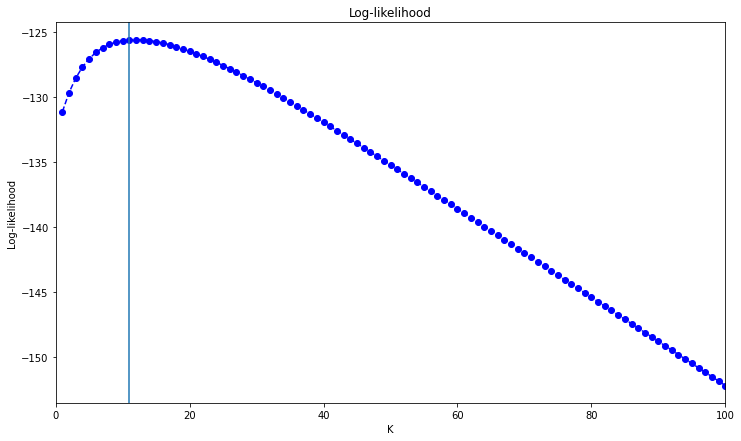

In [96]:
K = np.arange(1, 101, 1)

log_likelihoods_normal = try_ks(K)
plot_log_likelihood(K, log_likelihoods_normal)

# TODO: move this down to where log_likilihoods_mov is defined
# log_likelihoods_mov = try_ks(K, mov_flag=True)
# plot_log_likelihood(K, log_likelihoods_mov)

In [87]:
def bestK(log_likelihoods):
    '''
    Return the k-factor that maximizes the log-likelihoods.
    
    params
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    bestK: k-factor that maximizes the log-likelihoods
    '''
    return log_likelihoods.index(max(log_likelihoods))

In [88]:
# Get simple Elo ratings using the best k-factor
allratings = run_tournament(fulldf, K=bestK(log_likelihoods_normal))
allratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1701.649697
Jayson Shaw,1692.910221
Joshua Filler,1650.774312
Fedor Gorst,1643.761536
Niels Feijen,1643.455154
Shane Van Boening,1637.251895
Albin Ouschan,1633.608892
Mario He,1613.381724
Dennis Orcollo,1610.190063
David Alcaide,1604.546076


In [89]:
# TODO: clean up / add comment
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[0:25].index)]

Eklent Kaci               117
Jayson Shaw               118
Joshua Filler             108
Fedor Gorst                85
Niels Feijen              141
Shane Van Boening         167
Albin Ouschan             119
Mario He                   87
Dennis Orcollo             82
David Alcaide             101
Liu Haitao                 50
Denis Grabe                91
Ralf Souquet              122
Carlo Biado                60
Ko Pin Yi                  69
Ko Ping-Chung              58
Maximilian Lechner         55
Francisco Sanchez Ruiz     84
Mieszko Fortunski          59
Jeffrey de Luna            48
Alex Kazakis               95
Jeffrey Ignacio            46
Darren Appleton            94
Jung-Lin Chang             25
Mateusz Sniegocki          66
dtype: int64

In [90]:
# TODO: clean up / add comment
allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-40:len(players.value_counts())]

,ratings
Chris Lawson,1479.857618
Tony Chohan,1479.795060
Michael Yednak,1479.765461
Mohammed Hassan,1479.511247
Ali Abdulhadi Almeri,1479.490721
Ivar Saris,1479.472184
Jason Theron,1479.369746
Mohammad Soufi,1479.333461
Gabriel Syarov,1479.162393
Maksim Dudanets,1478.906472


In [91]:
# TODO: clean up / add comment
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-25:len(players.value_counts())].index)]

Ken Thompson              4
Nadim Okbani              4
Carlos Cabello            4
Lenny Rakers              4
Mark Todd                 4
Ali al-Obaidly           11
Abder Rehman Mebarki      4
Roberto Gomez            17
Tomasz Kaplan            35
Luu Minh Phuc            11
Mariusz Skoneczny        13
Alejandro Carvajal        7
Meshaal al-Murdhi         7
Huidji See               11
Kostas Koukiadakis       20
Enrique Rojas             5
Bashar Hussain           13
Stevie Moore              5
Gary Lutman               7
Sundeep Gulati            5
Adam Mscisz               5
Earl Strickland          19
Robert Hart               6
Abdul Latif al-Fawal     11
Mohammad-Ali Berjaoui    11
dtype: int64

In [92]:
# Filter ratings for players in the validation set 
val_players_ratings = allratings.iloc[np.array(names)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(fullPlayerList))
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1701.649697
Niels Feijen,1643.455154
Albin Ouschan,1633.608892
David Alcaide,1604.546076
Denis Grabe,1601.973149
Ralf Souquet,1601.945088
Mieszko Fortunski,1578.747271
Alex Kazakis,1575.701370
Darren Appleton,1570.862456
Casper Matikainen,1549.774265


In [93]:
get_accuracy(val_data, val_players_ratings)

0.625

In [94]:
def get_accuracies_for_ks(K_range, mov_flag=False):
    '''
    Calculate the accuracies for a range of k-factors.
    
    params
    K_range: Range of k-factors to try
    mov_flag: True if the margin of victory adjustment should be used
    
    return
    accuracies: List of accuracies per k-factor
    '''
    accuracies = []
    for k in K_range: 
        # Get ratings 
        if mov_flag:
            allratings = run_tournament_mov(fulldf, K=k)
        else:
            allratings = run_tournament(fulldf, K=k)

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(names)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(fullPlayerList))

        accuracies.append(get_accuracy(val_data, val_player_ratings))
        
    return accuracies


def plot_accuracies(K_range, accuracies):
    '''
    Plot the accuracies and find the optimal k-factor based on accuracy.
    
    params
    K_range: Range of k-factors to try
    accuracies: List of accuracies per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    ax = plt.axes()
    ax.plot(K_range, accuracies, '--bo')
    ax.axvline(accuracies.index(max(accuracies)))
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Accuracy',
           title='Accuracies');

    print("Optimal K is " + str(accuracies.index(max(accuracies))))
    plt.show()

Optimal K is 19


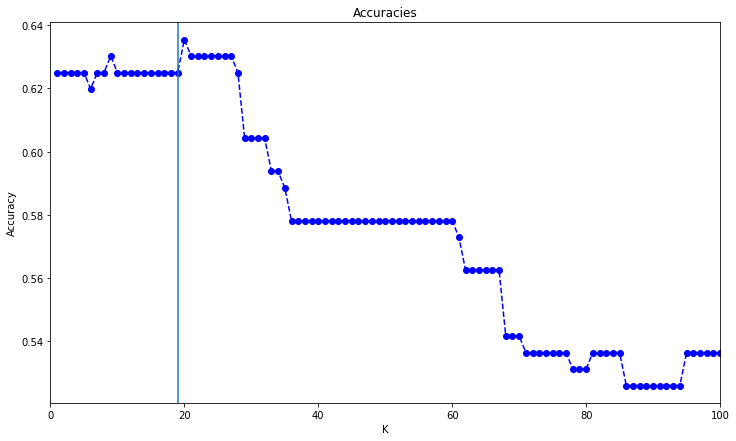

NameError: name 'run_tournament_mov' is not defined

In [97]:
accuracies_normal = get_accuracies_for_ks(K)
plot_accuracies(K, accuracies_normal)

accuracies_mov = get_accuracies_for_ks(K, mov_flag=True)
plot_accuracies(K, accuracies_mov)

# Margin of Victory Adjustment

In [ ]:
def get_score_diff(row):
    '''
    Score difference for a match.
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    return np.abs(row['playerARacks'] - row['playerBRacks'])

# Margin of Victory Multiplier = LN(ABS(PD)+1) * (2.2/((ELOW-ELOL)*.001+2.2))


def run_tournament_mov(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        # Add margin of victory multiplier to K
        # https://math.stackexchange.com/questions/850002/improving-the-elo-rating-system-to-account-for-game-results
        mov = np.log(get_score_diff(row) + 0.5) * (2.2 / ((elo_ratings[winner] - elo_ratings[loser]) * 0.001 + 2.2))
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K * mov, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [ ]:
K = np.arange(1, 51, 1)

log_likelihoods_mov = try_ks(K, mov_flag=True)
plot_log_likelihood(K, log_likelihoods_mov)

In [ ]:
# Use best K determined by maximizing the log-likelihood
ratings_mov = run_tournament_mov(fulldf, K=bestK(log_likelihoods_mov))
ratings_mov.sort_values(by='ratings', ascending = False)[0:25]

In [ ]:
# Filter ratings for players in the validation set 
val_players_ratings = ratings_mov.iloc[np.array(names)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(fullPlayerList))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

# Ratings Based on Priors

WPA 2019 Rankings https://wpapool.com/previous-ranking/

# Update Posterior Ratings after Predator CLP

In [ ]:
def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [ ]:
posterior_ratings = run_tournament_with_prior_ratings(val_data, priorratings = CLPratings)

In [ ]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

# FARGO

In [39]:
fargo = pd.read_csv("data/FARGOratings.csv").drop(columns= "Unnamed: 0")
fargo = fargo.set_index("player")
fargo.loc["Marc Bijsterbosch"] = 772

In [40]:
get_accuracy(val_data, fargo)

0.6145833333333334

In [41]:
get_loglikelihood(val_data, fargo)

-128.2167411794048

# WPA Rankings

In [49]:
wpaRankings = pd.read_csv("data/WPArankings.csv").drop(columns= "Unnamed: 0")
wpaRankings = wpaRankings.set_index("player")
wpaRankings

,rankings
player,
Ping Chung Ko,25263
Joshua Filler,23512
Shane Van Boening,22574
Fedor Gorst,19037
Jung-Lin Chang,19012
...,...
Torsten Schmitt,300
Yu-Hsuan Fan,200
Szu-Ting Kuo,200


In [50]:
def get_accuracy_wpa(newdata, ratings):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        playerA = ratings.loc[row.loc['playerA']][0]
        playerB = ratings.loc[row.loc['playerB']][0]
        accuracy.append(int(playerA > playerB) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [51]:
get_accuracy_wpa(val_data, wpaRankings)

0.53125


# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [469]:

def run_tournament(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating

    return(elo_ratings)

In [470]:
ratings = run_tournament()

KeyError: 'WinnerName'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = val_data[val_data.Group == 8]
prelims = val_data[val_data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined

# Varying K 

In [52]:
# Elo Rating System 
# Constants
INITIAL_RATING = 0
ELO_WIDTH = 400

def expected_Glickman(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** (-1 * (A - B) / elo_width))
    return( proba )

def standard_update_elo_Glickman(Rpre, Ropp, S, k, m0, elo_width):
    expected_win = expected(Rpre, Ropp, elo_width)
    T = 14
    if (k *(S-expected_win)) <= (T * np.sqrt(m0)[0]): 
        B = 0
    else: 
        B = k *(S-expected_win) - (T * np.sqrt(m0)[0])
    Rpost = Rpre + k *(S-expected_win) + B
    return Rpost

def special_update_elo_Glickman(Rpre, Ropp, N, WL, m, elo_width):
    Rpost = (N * Rpre + m * Ropp + WL*elo_width)/(N + m)
    return Rpost





def run_tournament_varyingK(data, priorratings, priorgames, ELO_WIDTH = ELO_WIDTH, dictflag=False, consolidation = False):
    
    # Initialize Elo Ratings
    tournamentgames = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    elo_ratings = priorratings
    WLrecord = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    opponentrating = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        playerA = row["playerA"]
        playerB = row["playerB"]
        if consolidation: 
            playerA = switcher(row["playerA"])
            playerB = switcher(row["playerB"])
            
        tournamentgames.loc[playerA] += 1
        tournamentgames.loc[playerB] += 1
        mA = tournamentgames.loc[playerA]
        mB = tournamentgames.loc[playerB]
#         print(tournamentgames)
        
        Apre = elo_ratings.loc[playerA][0]
        Bpre = elo_ratings.loc[playerB][0]
        SA = row['playerARacks'] > row['playerBRacks'] 
        SB = row['playerBRacks'] > row['playerARacks'] 
        
        if SA: 
            WLrecord.loc[playerA] += 1
        else: 
            WLrecord.loc[playerA] -= 1
            
        if SB: 
            WLrecord.loc[playerB] += 1
        else: 
            WLrecord.loc[playerB] -= 1

        if dictflag:
            NA = priorgames.loc[playerA][0]
            NB = priorgames.loc[playerB][0]
        else:
            NA = priorgames[playerA]
            NB = priorgames[playerB]
            

        
        if NA < 50: 
            ANr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Apre)**2)
        else: 
            ANr = 50
        if NB < 50: 
            BNr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Bpre)**2)
        else: 
            BNr = 50
            
        Ne = min(ANr, BNr)
        
        if NA <=8: 
            Apost = special_update_elo_Glickman(Apre, Bpre, NA, WLrecord.loc[playerA][0], mA, ELO_WIDTH)
        else: 
            K = 800/ (NA + Ne)
            Apost = standard_update_elo_Glickman(Apre, Bpre, SA, K, mA, ELO_WIDTH)
        
        if NB <= 8: 
            Bpost = special_update_elo_Glickman(Bpre, Apre, NB, WLrecord.loc[playerB][0], mB, ELO_WIDTH)
        else: 
            K = 800/ (NB + Ne)
            Bpost = standard_update_elo_Glickman(Bpre, Apre, SB, K, mB, ELO_WIDTH)
        
        if dictflag:
            priorgames.loc[playerA][0] += 1
            priorgames.loc[playerB][0] += 1 
        else:
            priorgames[playerA] += 1
            priorgames[playerB] += 1
        
        elo_ratings.loc[playerA][0] = Apost
        elo_ratings.loc[playerB][0] = Bpost
    return(elo_ratings)



In [53]:
players.value_counts()[np.array(names)]

Chris Melling         59
Albin Ouschan        119
Kelly Fisher           2
Eklent Kaci          117
Niels Feijen         141
Ralf Souquet         122
Chris Robinson        10
Mieszko Fortunski     59
David Alcaide        101
Darren Appleton       94
Billy Thorpe          31
Naoyuki Oi            43
Kristina Tkach         1
Roberto Gomez         17
Marc Bijsterbosch     46
Alex Kazakis          95
Casper Matikainen     24
Denis Grabe           91
Jasmin Ouschan         4
dtype: int64

In [54]:
playergames = players.value_counts()
print(playergames)



Shane Van Boening         167
Niels Feijen              141
Ralf Souquet              122
Albin Ouschan             119
Jayson Shaw               118
                         ... 
Kristina Tkach              1
Phi Le                      1
Stephen Webber              1
Reymart Lin                 1
Gindac Ciprian Gabriel      1
Length: 1182, dtype: int64


In [55]:
ratings = run_tournament_varyingK(val_data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1918.150734
Niels Feijen,1767.534626
Denis Grabe,1737.723000
Albin Ouschan,1727.830744
Mieszko Fortunski,1715.613294
David Alcaide,1714.275811
Naoyuki Oi,1675.920956
Alex Kazakis,1672.936705
Ralf Souquet,1666.393895
Casper Matikainen,1646.030959


In [56]:
allratings

,ratings
Shane Van Boening,1637.251895
Niels Feijen,1643.455154
Ralf Souquet,1601.945088
Albin Ouschan,1633.608892
Jayson Shaw,1692.910221
...,...
Kristina Tkach,1494.171065
Phi Le,1494.785533
Stephen Webber,1494.906844
Reymart Lin,1494.924111


In [57]:
# init = pd.DataFrame(np.zeros_like(allratings), index = allratings.index).rename(columns={0:'ratings'})
playersgreaterthan10 = players.value_counts()[players.value_counts() > 10]

playergamedictionary = {}

players.value_counts().index.unique()

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        print(i)
        pass
    else:
        playergamedictionary[i] = "Player " + str(players.value_counts()[players.value_counts().index == i][0])

playergamedictionary
fulldf_version = fulldf.copy()
fulldf_version


Chris Robinson
Jasmin Ouschan
Kelly Fisher
Kristina Tkach


,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4878,4878,6,NaN,2020-12-02,Jayson Shaw,5,Shane Van Boening,4,2020 Mosconi Cup
4879,4879,8,NaN,2020-12-02,Fedor Gorst,5,Corey Deuel,2,2020 Mosconi Cup
4880,4880,10,NaN,2020-12-02,Jayson Shaw,5,Billy Thorpe,3,2020 Mosconi Cup
4881,4881,12,NaN,2020-12-03,Joshua Filler,5,Skyler Woodward,0,2020 Mosconi Cup


In [58]:
playergamedictionary

{'Bora Anar': 'Player 10',
 'Robbie Capito': 'Player 10',
 'Elliott Sanderson': 'Player 10',
 'Artem Koshovyi': 'Player 10',
 'Michael Yednak': 'Player 10',
 'Satoshi Kawabata': 'Player 10',
 'Francesco Candela': 'Player 10',
 'Moritz Lauwereyns': 'Player 10',
 'Abdullah al-Yousif': 'Player 10',
 'Szu-Ting Kuo': 'Player 10',
 'Miguel Silva': 'Player 9',
 'Donny Branson': 'Player 9',
 'Kenichi Uchigaki': 'Player 9',
 'Tom Teriault': 'Player 9',
 'Jeppe Thyde': 'Player 9',
 'Raj Hundal': 'Player 9',
 'Salah Al Riwani': 'Player 9',
 'Kings Santy': 'Player 9',
 'Mustafa Alnar': 'Player 9',
 'Babken Melkonyan': 'Player 9',
 'Sean Morgan': 'Player 9',
 'Menelaos Lolas': 'Player 9',
 'Edmond Zaja': 'Player 9',
 'Attila Bezdan': 'Player 9',
 'Charlie Williams': 'Player 9',
 'John Schmidt': 'Player 9',
 'Han Haoxiang': 'Player 9',
 'Ali Maghsoud': 'Player 9',
 'Blake Baker': 'Player 9',
 'Nguyễn Anh Tuấn': 'Player 9',
 'Michael Hutcheson': 'Player 9',
 'Do The Kien': 'Player 9',
 'Pepijn DeWit'

In [59]:
def switcher(argument):
        switcher = playergamedictionary

        # get() method of dictionary data type returns 
        # value of passed argument if it is present 
        # in dictionary otherwise second argument will
        # be assigned as default value of passed argument
        val = switcher.get(argument, "nothing")
        if val == "nothing":
            return argument
        else:
#             print(val)
            return val
def consolidatestrings(series):
    
    lst = []
    for idx, item in enumerate(series): 
        lst.append(switcher(item))
#     print(lst)
    return(lst)
   
    

fulldf_version["playerA"] = consolidatestrings(fulldf_version["playerA"])
fulldf_version["playerB"] = consolidatestrings(fulldf_version["playerB"])

fulldf_version

,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14,Ernesto Dominguez,11,Player 7,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14,Player 1,11,Player 4,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14,Player 2,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14,Francisco Bustamante,11,Player 1,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4878,4878,6,NaN,2020-12-02,Jayson Shaw,5,Shane Van Boening,4,2020 Mosconi Cup
4879,4879,8,NaN,2020-12-02,Fedor Gorst,5,Corey Deuel,2,2020 Mosconi Cup
4880,4880,10,NaN,2020-12-02,Jayson Shaw,5,Billy Thorpe,3,2020 Mosconi Cup
4881,4881,12,NaN,2020-12-03,Joshua Filler,5,Skyler Woodward,0,2020 Mosconi Cup


In [60]:
filtered_list = list(set(playergamedictionary.values()))
for i in list(players.value_counts()[players.value_counts() > 10].index):
    filtered_list.append(i)

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        filtered_list.append(i)
    

# filtered_list

In [61]:
# Get ratings 


init = pd.DataFrame(np.zeros(len(filtered_list)), index = index).rename(columns={0:'ratings'})
allratings = run_tournament_varyingK(fulldf_version, init + 1500, init, dictflag =True, consolidation=True)
allratings.sort_values(by='ratings', ascending = False)[0:40]


NameError: name 'index' is not defined

In [ ]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in allratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(allratings.index == player)[0][0])
playersindex
names

In [ ]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = allratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

# # Filter ratings 
# CLPratings = allratings.iloc[np.array(names)]
# # CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
# CLPratings = CLPratings.set_index( index )
CLPratings.sort_values(by='ratings', ascending = False)

In [ ]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
#         print(proba)
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [ ]:
get_loglikelihood(val_data, CLPratings)

In [62]:
ratings = run_tournament_varyingK(val_data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1912.123345
Niels Feijen,1761.409050
Denis Grabe,1740.461103
Albin Ouschan,1737.066198
David Alcaide,1728.970348
Mieszko Fortunski,1691.959995
Naoyuki Oi,1683.411651
Alex Kazakis,1678.863331
Ralf Souquet,1654.830472
Darren Appleton,1625.672872
